In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pandas as pd

In [15]:
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')
skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')

sales = sales.join(skus, on='SKU')

covid_response = pd.read_excel('../../../data/oxford/OxCGRT_timeseries_all.xlsx')

<AxesSubplot:>

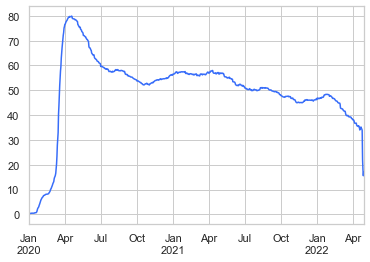

In [16]:
avg_covid_response = covid_response.select_dtypes('number').mean()
avg_covid_response.index = pd.to_datetime(avg_covid_response.index)
avg_covid_response.plot()

<AxesSubplot:>

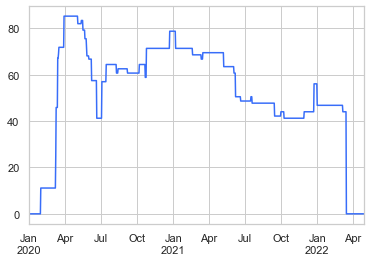

In [32]:
# covid_response only with country_name equals United States
covid_response_us = covid_response[covid_response['country_name'] == 'Spain'].select_dtypes('number').squeeze().fillna(0)
covid_response_us.index = pd.to_datetime(covid_response_us.index)
covid_response_us.plot()

#### Clean dataset

In [33]:
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.loc[sales['date'] > '2020-04-01']
sales['sales'] = sales['sales'].fillna(1)

In [34]:
timeframe_of_interest = pd.date_range(start=sales['date'].min(), end=sales['date'].max())

<AxesSubplot:xlabel='ds'>

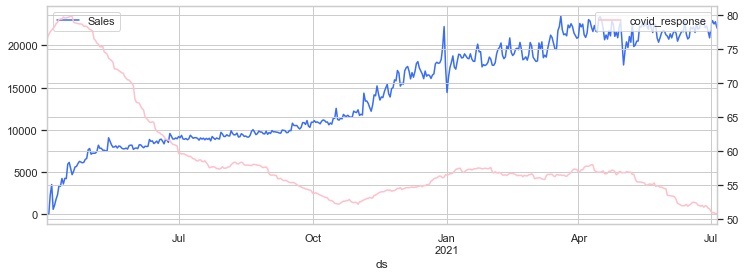

In [41]:
full_training_set = sales.groupby('date')['sales'].sum().reindex(timeframe_of_interest, fill_value=0).reset_index()
full_training_set.rename(columns={'index': 'ds', 'sales': 'y'}, inplace=True)

full_training_set = full_training_set.join(avg_covid_response.rename('covid_response'), on='ds')

fig, ax = plt.subplots(figsize=(12, 4))

full_training_set.plot(ax=ax, x='ds', y='y', label='Sales')

ax2 = ax.twinx()

full_training_set.plot(ax=ax2, x='ds', y='covid_response', color='pink')

In [42]:
splitting_date = '2021-04-01'

training_set = full_training_set.loc[full_training_set['ds'] < splitting_date]
validation_set = full_training_set.loc[full_training_set['ds'] >= splitting_date]

#### NeuralProphet

In [43]:
import neuralprophet
m = neuralprophet.NeuralProphet()

In [44]:
m.add_future_regressor('covid_response')
m.add_country_holidays(country_name='US', lower_window=-4, upper_window=2)

In [45]:
m.fit(training_set)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  a

  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 1.32E+00


  0%|          | 0/116 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.87E-02, min: 1.32E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.80E-02
Epoch[279/279]: 100%|██████████| 279/279 [00:12<00:00, 21.64it/s, SmoothL1Loss=0.000325, MAE=356, RMSE=508, RegLoss=0]       


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.250391,34973.116866,40485.595295,0.0
1,1.200408,33867.941685,39567.088835,0.0
2,1.146150,32658.832890,38485.003863,0.0
3,1.086404,31296.347012,37235.570913,0.0
4,1.015432,29683.492552,35886.132491,0.0
...,...,...,...,...
274,0.000326,356.486258,504.274189,0.0
275,0.000325,355.692907,497.930391,0.0
276,0.000325,355.616801,507.014825,0.0
277,0.000325,355.545041,510.947946,0.0


In [51]:
training_set

,ds,y,covid_response
0,2020-04-02,19.400,76.692054
1,2020-04-03,13.000,77.159946
2,2020-04-04,2258.550,77.575297
3,2020-04-05,3486.810,77.805459
4,2020-04-06,547.500,78.095784
...,...,...,...
359,2021-03-27,22582.900,56.849351
360,2021-03-28,22239.589,57.144595
361,2021-03-29,21484.170,57.322270
362,2021-03-30,21180.100,57.289892


In [61]:
future = m.make_future_dataframe(training_set, regressors_df=pd.DataFrame({'covid_response': 0}, index=[0]), periods=200, n_historic_predictions=200)
future['covid_response'] = future['covid_response'].fillna(0)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.725% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)



In [62]:
forecast = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)

WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\time_dataset.py:491: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

<AxesSubplot:xlabel='ds'>

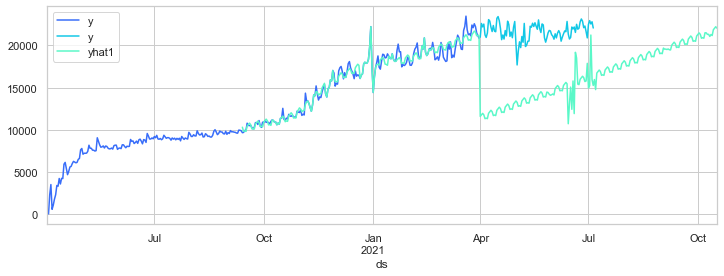

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))

training_set.plot(x='ds', y='y', ax=ax)
validation_set.plot(x='ds', y='y', ax=ax)
forecast.plot(x='ds', y='yhat1', ax=ax)